# <i class="fas fa-star"></i>&hairsp;T06: Unsupervised Classification of Projection Neurons

This tutorial demonstrates how to use pysnt to cluster populations of cells using [Persistent Homology](https://en.wikipedia.org/wiki/Topological_data_analysis), a powerful topological data analysis technique that captures multi-scale geometric features of neuronal structures.


```{hint}
By the end of this notebook, you will be able to:
- Understand the concept of Persistent Landscapes
- Use PySNT for unsupervised classification of cells 

**Estimated Time**: 30 minutes
```


```{warning}
**Extra Requirements:** This tutorial requires [scikit-learn](https://scikit-learn.org/) and [SciPy](https://scipy.org/):

```bash
mamba activate pysnt
mamba install scikit-learn scipy
```

## Introduction
Persistent homology allows us to quantify the branching complexity of neuronal morphologies by tracking topological features as they appear and disappear across multiple scales. For neurons, we generate persistence diagrams—collections of birth-death pairs representing when branches emerge and terminate—using sublevel set filtrations over neuronal arbors with respect to morphological descriptor functions (e.g., radial distance, path length). These diagrams provide a compact topological signature of each cell's branching pattern.

To compare neurons, we transform persistence diagrams into **persistence landscapes**—continuous piecewise-linear functions that can be compared using standard distance metrics. The distance between two cells is computed as the **Lp-norm** between their landscape functions: we measure the difference at each sample point and aggregate these differences. Common approaches include summing absolute differences, taking Euclidean distance (root of summed squared differences), or using Chebyshev distance (the maximum difference across all points). This mathematical framework allows us to quantify morphological similarity and perform clustering.

**Key References:**
- For the neuronal filtration algorithm: [Kanari, L., Dłotko, P., Scolamiero, M. et al. A Topological Representation of Branching Neuronal Morphologies. Neuroinform 16, 3–13 (2018)](https://link.springer.com/article/10.1007/s12021-017-9341-1)
- For persistence landscapes: [Bubenik, P. (2015). Statistical topological data analysis using persistence landscapes. Journal of Machine Learning Research. 16. 77-102.](http://jmlr.org/papers/v16/bubenik15a.html)

We can compute both persistence diagrams and landscapes directly from reconstructions using {class}`PersistenceAnalyzer <pysnt.analysis.PersistenceAnalyzer>`

A distinctive feature of SNT is its support for multiple supports multiple filtering functions. {class}`PersistenceAnalyzer <pysnt.analysis.PersistenceAnalyzer>` supports functions capturing geometric extent (geodesic/radial), branching complexity (centrifugal/path order), or directional bias:

- **Radial Distance**: Straight-line (Euclidean) distance from each node to the root in 3D space. Reveals spatial spreading patterns independent of branching complexity. Originally used by Kanari et al.

- **Geodesic Distance**: Cumulative path length from each node to the root following the tree structure. Captures both cable length and tortuosity (contraction) and reveals branches that extend far along the arbor.

- **Centrifugal Branch Order**: Reverse Strahler ordering starting from tips (order 1) toward the root. Emphasizes branching complexity from the terminal branches' perspective.

- **Path Order**: Hierarchical ordering based on SNT's reconstruction hierarchy, where primary paths have order 1 and children increase incrementally. Reflects the traced path structure.

- **XYZ Coordinate**: Spatial position along a cartesian axis. Reveals directional growth and organization patterns along an axis.


## Scope and Dataset

We will use persistent homology to cluster three populations of fully reconstructed projection neurons from layers 5 and 6 of the mouse motor cortex, each with distinct anatomical targets:

- **Group 1: Layer 6 Corticothalamic (L6 CT)** – Neurons projecting primarily to the thalamus
- **Group 2: Layer 5 Pyramidal Tract (L5 PT)** – Two subpopulations with [distinct transcriptional profiles and functional roles](#data-sources-and-references):
  - **Group 2a: L5 PT TH** Projects predominantly to the thalamus, without hindbrain projections
  - **Group 2b: L5 PT MY** Projects to the medulla, without thalamic projections

**Why this dataset?** These populations have been well studied and exhibit differences in both branching and axonal projection patterns, making them ideal for testing whether topological features can recover known biological classifications in an unsupervised manner.

**Data source:** All reconstructions are from the [Mouselight database](#data-sources-and-references).


## Setup and Initialization

We'll start first by making sure all of the required dependencies have been installed:

In [26]:
# Check for required dependencies
try:
    import sklearn
    import scipy
    print("✓ All required packages are installed")
except ImportError as e:
    print(f"✗ Missing package: {e.name}")
    print("Please install missing packages with either:")
    print("  pip install scikit-learn scipy")
    print("  mamba install scikit-learn scipy")

✓ All required packages are installed


Next—as always—we start by initializing pysnt:

In [27]:
import pysnt
pysnt.initialize()

The most important pysnt class we will be using is {class}`pysnt.analysis.PersistenceAnalyzer`. From scikit-learn and SciPy we will also be using the [sklearn.cluster](https://scikit-learn.org/stable/api/sklearn.cluster.html#module-sklearn.cluster) and [scipy.cluster](https://docs.scipy.org/doc/scipy/reference/cluster.html) modules.

For convenience, we will use define pre-defined cell IDs for each group:

In [28]:
corticothalamic_ids = [
    'AA0103', 'AA0105', 'AA0188', 'AA0278', 'AA0390', 'AA0394',
    'AA0406', 'AA0577', 'AA0599', 'AA0633', 'AA0650', 'AA0781',
    'AA0784', 'AA0799','AA0817', 'AA0837', 'AA0838', 'AA0844']

pt_thalamic_ids = [
    'AA0115', 'AA0122', 'AA0181', 'AA0182', 'AA0245', 'AA0261',
    'AA0415', 'AA0617', 'AA0764', 'AA0780', 'AA0792', 'AA0926']

pt_medulla_ids = [
    'AA0012', 'AA0131', 'AA0133', 'AA0134', 'AA0169', 'AA0179',
    'AA0180', 'AA0576', 'AA0587', 'AA0788', 'AA0923', 'AA0587']


We can fetch all of these cells ({class}`pysnt.Tree` objects) from the [MouseLight database](https://ml-neuronbrowser.janelia.org/) using SNT's 
{class}`pysnt.io.MouseLightLoader`. We will keep the group identifier in the tree label, for easier tracking:

NB: The download of these morphologies may take a while

In [29]:
def fetch_reconstructions(id_list, group_label):
    """
    Download neuronal reconstructions from the MouseLight database.
    
    Parameters
    ----------
    id_list : list of str
        List of MouseLight cell IDs to download
    group_label : str
        Group label to append to each tree's identifier (e.g., 'L6 CT', 'L5 PT', etc.)
    
    Returns
    -------
    list of Tree
        Successfully loaded Tree objects with updated labels
    """
    from pysnt.io import MouseLightLoader
    
    tree_list = []
    print(f"Fetching {len(id_list)} reconstructions for group: {group_label}")
    
    for idx, tree_id in enumerate(id_list, 1):
        loader = MouseLightLoader(tree_id)
        
        # Check database availability
        if idx == 1 and not loader.isDatabaseAvailable():
            raise RuntimeError("MouseLight database is not available")
    
        # Dowload full tree
        tree = loader.getTree()
        
        # Update label
        tree.setLabel(f"{tree.getLabel()} {group_label}")
        tree_list.append(tree)
        print(f"\r  Progress: [{idx}/{len(id_list)}] ✓ Loading... {tree_id}", end='', flush=True)
    
    # Summary
    print(f"\nSuccessfully loaded {len(tree_list)}/{len(id_list)} reconstructions")
    return tree_list


corticothalamic_trees = fetch_reconstructions(corticothalamic_ids, 'Layer 6 CT')
pt_thalamic_trees = fetch_reconstructions(pt_thalamic_ids, 'Layer 5 PT-TH')
pt_medulla_trees = fetch_reconstructions(pt_medulla_ids, 'Layer 5 PT-MY')

original_groups = {
    'L6 CT': corticothalamic_trees,
    'L5 PT (Thalamus)': pt_thalamic_trees, 
    'L5 PT (Medulla)': pt_medulla_trees
    }

# For conveninence, store everything in a single list
all_trees = corticothalamic_trees + pt_thalamic_trees + pt_medulla_trees
all_labels = [tree.getLabel() for tree in all_trees]

Fetching 18 reconstructions for group: Layer 6 CT
  Progress: [18/18] ✓ Loading... AA0844
Successfully loaded 18/18 reconstructions
Fetching 12 reconstructions for group: Layer 5 PT-TH
  Progress: [12/12] ✓ Loading... AA0926
Successfully loaded 12/12 reconstructions
Fetching 12 reconstructions for group: Layer 5 PT-MY
  Progress: [12/12] ✓ Loading... AA0587
Successfully loaded 12/12 reconstructions


Now we can compute the persistence landscapes for all cells:

In [30]:
def get_landscapes(trees, num_landscapes, resolution, 
                    descriptor='radial', compartments='all'):
    """
    Compute persistence landscapes for a neuronal tree.
    
    Parameters
    ----------
    trees : list of Tree
        Full neuronal reconstructions
    num_landscapes : int
        Number of landscape functions
    resolution : int
        Number of sample points
    descriptor : str, optional
        Filtration function: 'radial', 'geodesic', 'centrifugal', etc. (default: 'radial')
    compartments : list of str, optional
        List of compartments to analyze: 'dendrite', 'axon', 'all' (default: ['all'])
        NB: Typically, when a dendritic arbor has multiple primary dendrites, specifying
            ['dendrite', 'soma'] is required to obtain a valid sub-tree.
    
    Returns
    -------
    numpy.ndarray
        Landscape array for specified compartment
    """
    import numpy as np
    from pysnt.analysis import PersistenceAnalyzer
    
    landscapes = []
    for tree in trees:
        # Consider only the specified compartment(s)
        subtree = tree.subTree(compartments)
        ls = PersistenceAnalyzer(subtree).getLandscape(
            descriptor,
            num_landscapes, 
            resolution,
        )
        landscapes.append(ls)
    
    return np.array(landscapes)

# Compute persistence landscapes for all neurons
num_landscapes = 500
resolution = 500
landscapes = get_landscapes(all_trees, num_landscapes, resolution, descriptor='radial')

print(f"Landscape array shape: {landscapes.shape}")
print(f"({landscapes.shape[0]} neurons × {num_landscapes} landscapes × {resolution} points)")

Landscape array shape: (42, 250000)
(42 neurons × 500 landscapes × 500 points)


Let's visualize the average of the first 10 persistence landscapes across all neurons in each group:

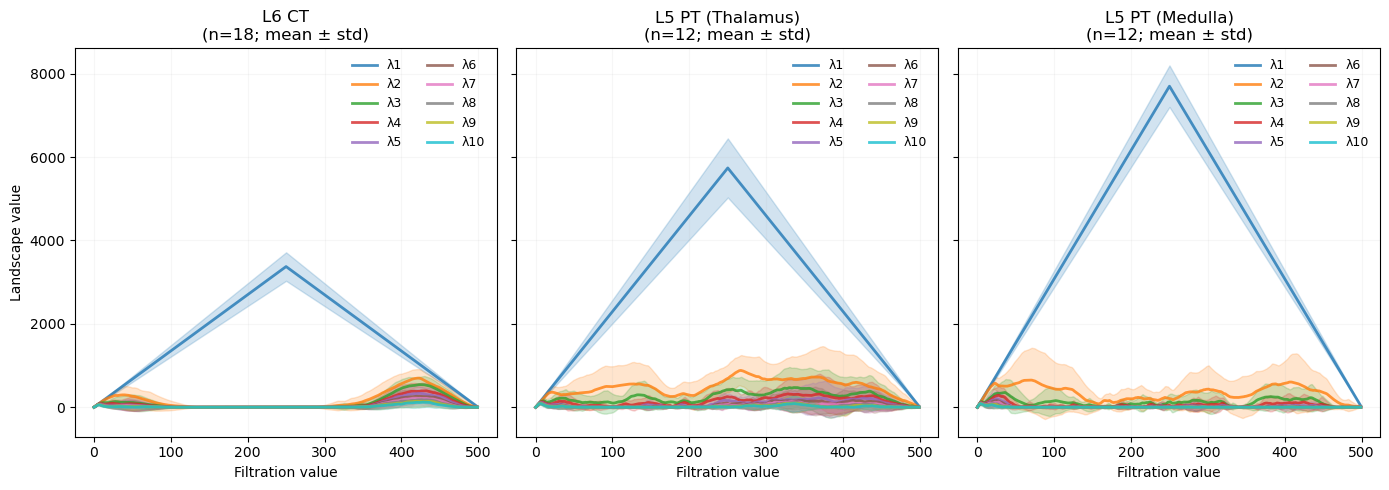

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_group_landscapes(all_ls, all_trees, groups,
                          top_k=10, show_std=False, figsize=(14, 5), cmap='tab10'):
    """
    Plot mean persistence landscapes for multiple groups of neurons.
    
    Parameters
    ----------
    all_ls : numpy.ndarray
        Reshaped landscape array of shape (n_neurons, n_landscapes, resolution)
    all_trees : list
        Flat list of all Tree objects corresponding to rows in all_ls
    groups : dict
        Dictionary mapping group labels to lists of Tree objects
    top_k : int, optional
        Number of top landscape functions to display (default: 10)
    show_std : bool, optional
        If True, plot shaded standard deviation regions (default: False)
    figsize : tuple, optional
        Figure size in inches (default: (15, 5))
    cmap : str or colormap, optional
        Colormap name for landscape colors (default: 'tab10')
    
    Returns
    -------
    fig, axes
        Matplotlib figure and axes objects
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Get dimensions from reshaped array
    n_neurons, num_landscapes, resolution = all_ls.shape
    
    # Create subplots
    n_groups = len(groups)
    fig, axes = plt.subplots(1, n_groups, figsize=figsize, sharey=True)
    if n_groups == 1:
        axes = [axes]  # Ensure axes is iterable
    
    # Get colormap
    color_map = plt.get_cmap(cmap)    
    x = np.arange(resolution)

    for ax, (group_label, group_trees) in zip(axes, groups.items()):
        # Get landscapes for this group by finding indices in all_trees
        group_indices = [i for i, tree in enumerate(all_trees) if tree in group_trees]
        group_ls = all_ls[group_indices]
        
        # Compute mean and std across all cells in group
        mean_ls = np.mean(group_ls, axis=0)
        std_ls = np.std(group_ls, axis=0)
        
        # Plot top K landscape functions with unique colors
        for i in range(min(top_k, num_landscapes)):
            color = color_map(i)
            
            # Plot standard deviation as shaded region if requested
            if show_std:
                ax.fill_between(x, 
                               mean_ls[i] - std_ls[i],
                               mean_ls[i] + std_ls[i],
                               color=color, alpha=0.2)
            
            # Plot mean line
            ax.plot(x, mean_ls[i], linewidth=2, color=color, 
                    label=f'λ{i+1}', alpha=0.8)
        
        ax.set_xlabel('Filtration value')
        title_suffix = '; mean ± std)' if show_std else ')'
        ax.set_title(f'{group_label}\n(n={len(group_indices)}{title_suffix}')
        ax.grid(True, alpha=0.1)
        
        # Add y-label to first panel only
        if ax == axes[0]:
            ax.set_ylabel('Landscape value')
        
        # Add legend inside each panel without border
        ax.legend(frameon=False, loc='best', fontsize=9, ncol=2)
    
    plt.tight_layout()
    return fig, axes


fig, axes = plot_group_landscapes(
    # Reshape into 3D array: (neurons, landscapes, sample_points) for easier slicing
    all_ls=landscapes.reshape(len(all_trees), num_landscapes, resolution),
    all_trees=all_trees,
    groups=original_groups,
    show_std=True
)
plt.show()

## Interpreting Persistence Landscapes

The plots display the topological signatures of branching patterns across the three cell populations. Each colored line represents a persistence landscape function (λ₁ through λ₁₀), which captures how branching features persist across different spatial scales as we move outward from the soma (we used 'radial distance' as filtering function).

### Key observations:

1. The first landscape (λ₁, blue) dominates – This is the most prominent topological feature and represents the primary branching structure. Notice how λ₁ has much larger values than λ₂, λ₃, etc., indicating a clear hierarchical organization in the branching topology.

2. Peak position and shape differ between groups:

 - L6 CT neurons: Earlier, broader peak (~250-300 μm) with moderate amplitude (~3500)
 - L5 PT (Thalamus): Mid-range peak (~300 μm) with highest amplitude (~6000)
 - L5 PT (Medulla): Later, sharper peak (~300 μm) with the highest amplitude (~7500)


3. Landscape ranking matters – The steep drop-off from λ₁ to lower-order landscapes (λ₂, λ₃, etc.) indicates that most topological complexity is captured by the primary structure. Higher-order landscapes (λ₆-λ₁₀) remain closer to zero, suggesting relatively simple branching hierarchies in all three groups.

4. Group-specific variability – The shaded regions (±1 standard deviation) show that L5 PT (Thalamus) neurons have the highest within-group variability in their primary branching pattern. The higher variability in L5 PT (Thalamus) neurons _may_ reflect greater morphological heterogeneity within this population. The L5 PT (Medulla) neurons, despite their dramatic branching, show more stereotyped morphologies within the population.

In [ ]:
def hcluster(landscapes):
    """
    Perform hierarchical clustering on persistence landscapes and plot dendrogram
    using Chebyshev (Manhattan) distances between persistence landscapes.
    
    The Chebyshev (Manhattan) distance between persistence landscapes is stable
    with respect to the bottleneck distance between persistence diagrams,
    providing theoretical guarantees for the clustering, see
    Bubenik, P. (2015) Journal of Machine Learning Research, 16, 77-102.
    
    Parameters
    ----------
    landscapes : numpy.ndarray
        Landscape matrix of shape (n_samples, n_features)
    group_labels : list of str
        Labels for each sample to display in dendrogram
    color_threshold : float, optional
        Distance threshold for dendrogram coloring (default: 3500)
    figsize : tuple, optional
        Figure size in inches (width, height) (default: (10, 13))
    
    Returns
    -------
    model : sklearn.cluster.AgglomerativeClustering
        Fitted clustering model for further analysis
    """
    from sklearn.cluster import AgglomerativeClustering
    import matplotlib.pyplot as plt
    
    # Fit hierarchical clustering model
    # distance_threshold=0 ensures we get the full dendrogram
    # n_clusters=None required when using distance_threshold
    model = AgglomerativeClustering(
        metric='manhattan',       # 'cityblock' distance (max absolute difference)
        linkage='complete',       # Maximum distance between clusters
        distance_threshold=0,     # Build full tree
        n_clusters=None           # Don't stop at predetermined cluster count
    )
    model.fit(landscapes)
    return model

landscapes = get_landscapes(all_trees, num_landscapes, resolution, descriptor='radial', compartments='axon')
model = hcluster(landscapes)

We can now use it to plot a dendrogram:


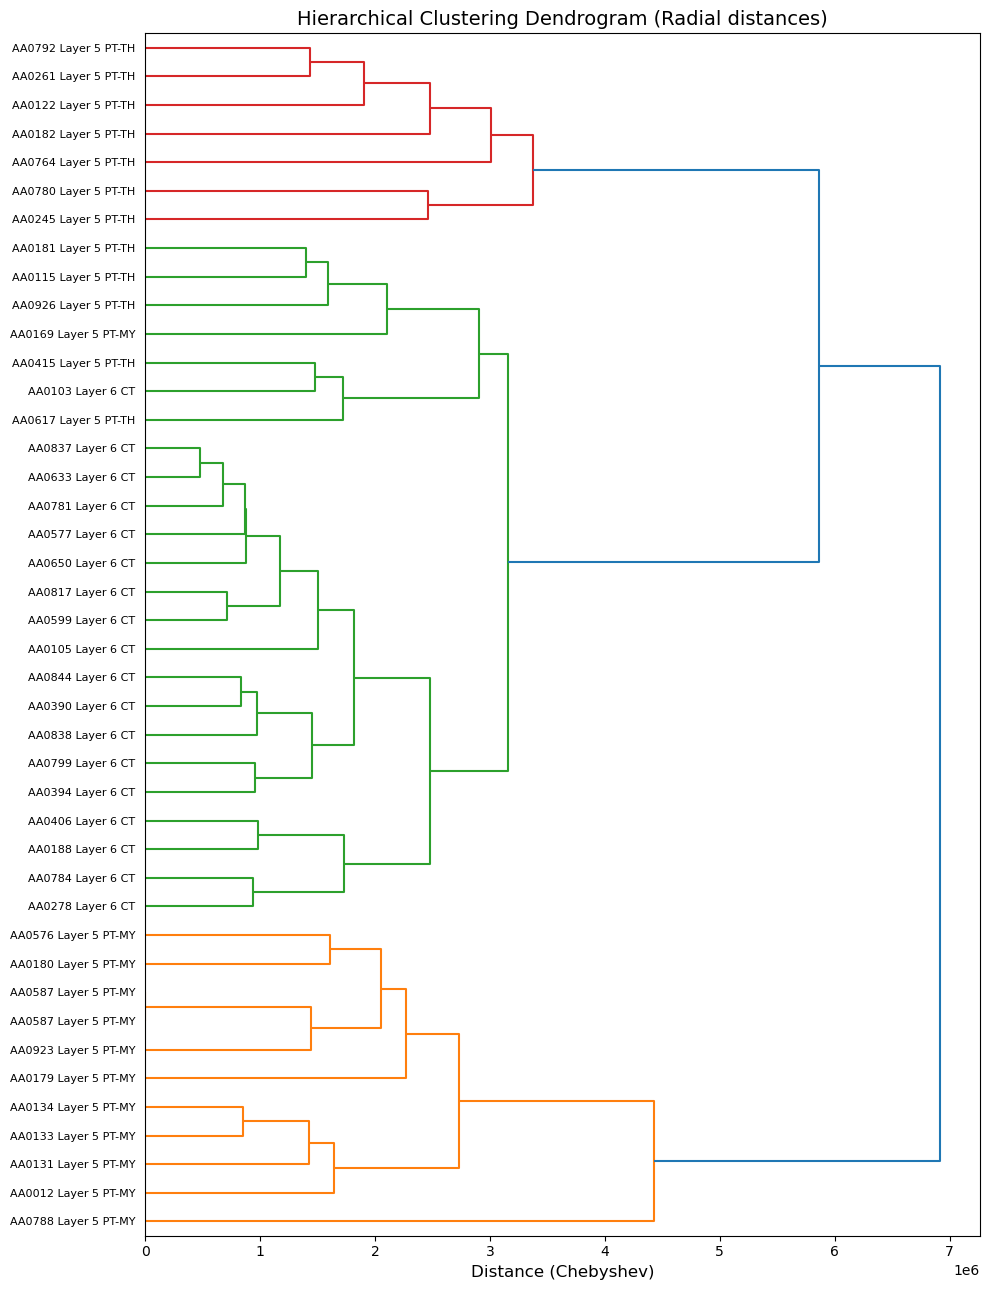

In [41]:
def plot_dendrogram(model, group_labels, color_threshold='default', orientation='right', figsize=(10, 13), title=''):
    """
    Plot a dendrogram from a fitted AgglomerativeClustering model and return group information.
    
    Returns
    -------
    dict
        Dictionary where keys are hex colors and values are lists of (leaf_idx, label) tuples
    """
    from scipy.cluster.hierarchy import dendrogram
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    
    # Build linkage matrix from AgglomerativeClustering results
    n_samples = len(model.labels_)
    
    counts = np.zeros(model.children_.shape[0])
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack([
        model.children_,
        model.distances_,
        counts
    ]).astype(float)
    
    # Create dendrogram plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Hierarchical Clustering Dendrogram ({title})', fontsize=14)
    ax.set_xlabel('Distance (Chebyshev)', fontsize=12)
    
    dend_data = dendrogram(linkage_matrix, 
               color_threshold=color_threshold,
               orientation=orientation,
               labels=group_labels)
    
    plt.tight_layout()
    plt.show()

    # Group leaves by color
    leaf_groups = {}
    for leaf_idx, color in zip(dend_data['leaves'], dend_data['leaves_color_list']):
        hex_color = mcolors.to_hex(color)
        if hex_color not in leaf_groups:
            leaf_groups[hex_color] = []
        leaf_groups[hex_color].append((leaf_idx, group_labels[leaf_idx]))
    
    return leaf_groups


dendrogram_groups = plot_dendrogram(model, all_labels, title='Radial distances')

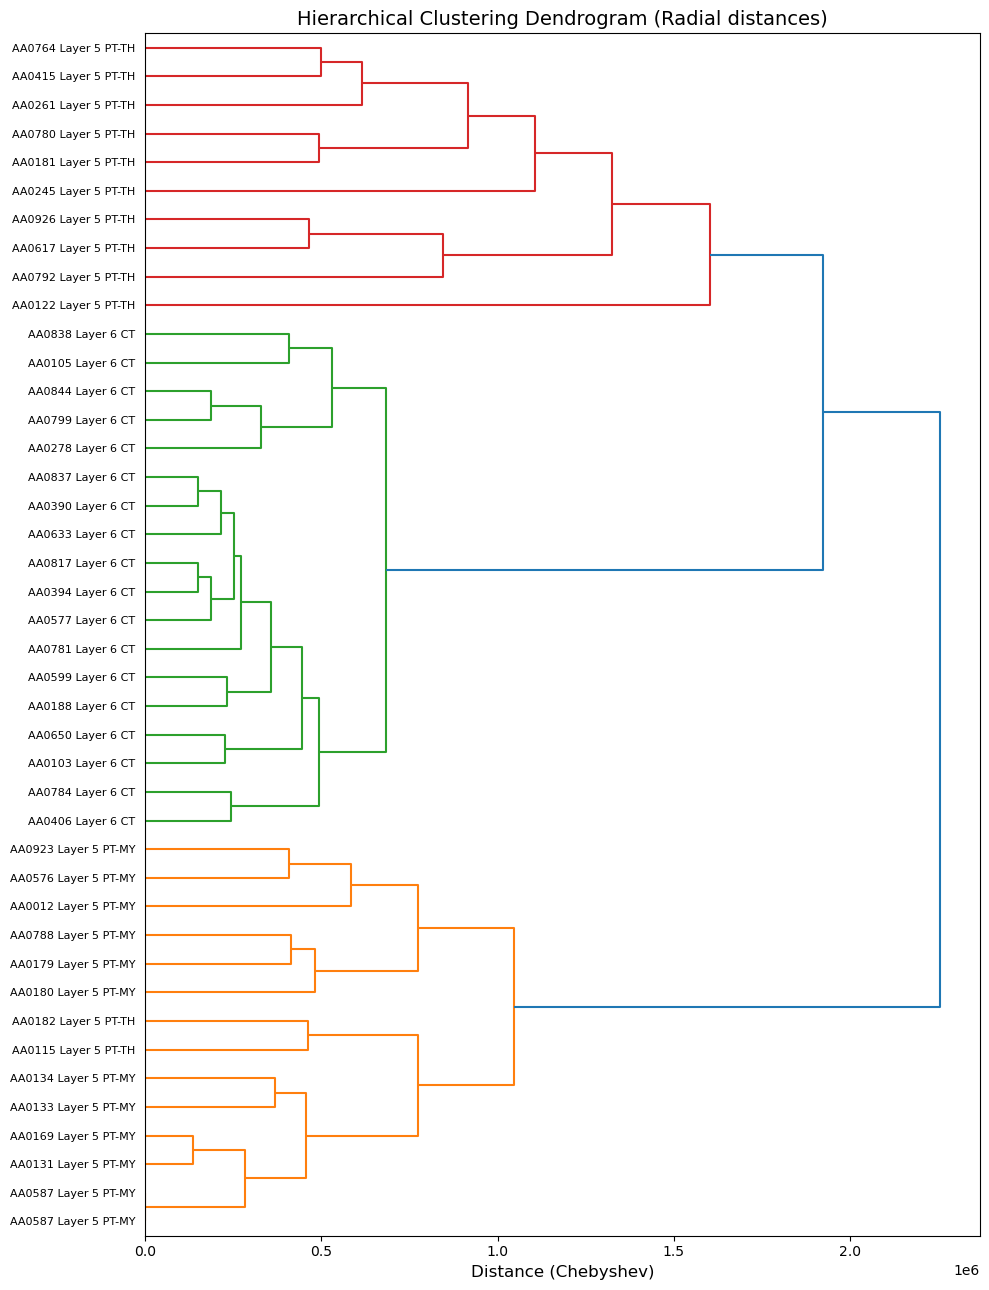

In [34]:
# Cut slightly higher to merge small groups
cut_distance = 1.7e6  # Just above the current cut
dendrogram_groups = plot_dendrogram(model, all_labels, color_threshold=cut_distance, title='Radial distances')

The dendrogram demonstrates remarkably accurate segregation of the three neuronal populations using only persistence landscapes from radial distances. Out of 42 neurons, only 2 are misclassified: AA0182 and AA0115 (both labeled as Layer 5 PT-TH) cluster with the Layer 5 PT-MY (medulla-projecting) group. This 95% accuracy using purely topological features—without any traditional morphometrics, anatomical annotations, or projection data—demonstrates the power of persistent homology for capturing biologically meaningful morphological differences.

Lets visualize the clustered groups: We'll define a small utility function for reusable 3D scenes:

{'type': matplotlib.figure.Figure,
 'data': <Figure size 2000x1000 with 3 Axes>,
 'metadata': {'source_type': 'ImagePlus_List',
  'imageplus_count': 3,
  'displayed_count': 3,
  'panel_layout': (1, 3),
  'title': None},
 'error': None}

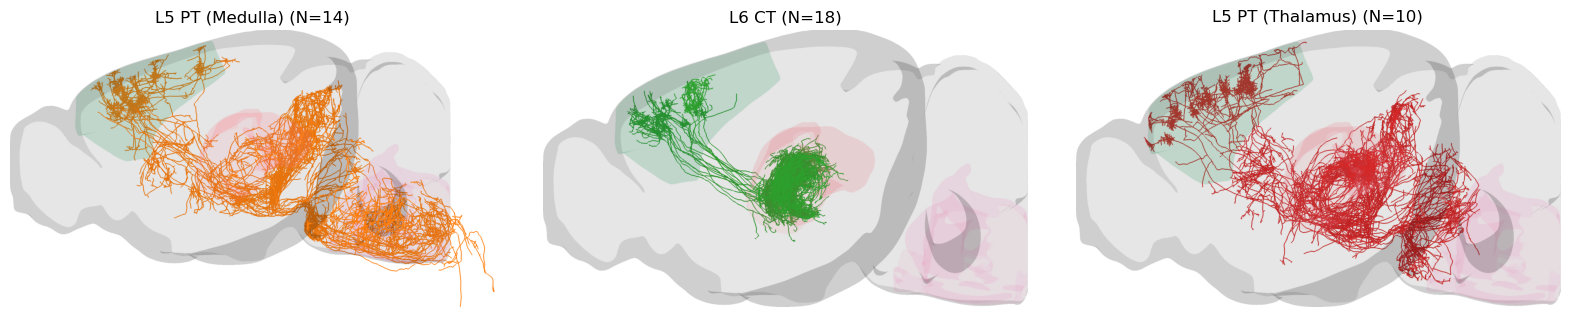

In [35]:
def init_viewer():
    """
    Initialize a 3D scene with pre-loaded meshes.

    Returns
    -------
    viewer : pysnt.viewer.Viewer3D
    """
    from pysnt.viewer import Viewer3D

    viewer = Viewer3D()
    viewer.setEnableDarkMode(False)
    viewer.loadRefBrain('allen ccf')

    # Retrieve meshes of relevant Allen CCF compartments
    for brain_region in ['Somatomotor areas', 'Thalamus', 'Medulla']:
        mesh = AllenUtils.getCompartment(brain_region).getMesh()
        mesh.setTransparency(95)
        viewer.add(mesh)
    return viewer


from pysnt.viewer import Viewer3D
from pysnt.annotation import AllenUtils

# First we define the dendogram labels (group labels in dendrogrammorder)
dendogram_group_labels = ['L5 PT (Medulla)', 'L6 CT', 'L5 PT (Thalamus)']

# Now we create a 3D scene for each group
snapshots = []
for group_num, (color, trees) in enumerate(dendrogram_groups.items()):

    # Assemble a 3D scene
    viewer = init_viewer()

    # Add trees in the group
    for leaf_idx, label in trees:
        tree = all_trees[leaf_idx]
        tree.setColor(color)
        viewer.add(tree)
    
    # Collect scene snaphot
    snapshot = viewer.snapshot('sagittal')
    snapshot_title = f'{dendogram_group_labels[group_num]} (N={len(trees)})'
    snapshot.setTitle(snapshot_title)
    snapshots.append(snapshot)

pysnt.display(snapshots, panel_layout=(1,3), figsize=(20,10))

Let's display the 'most' representative exemplar of each group:

Exemplars of clustered groups:


{'type': matplotlib.figure.Figure,
 'data': <Figure size 2000x1000 with 3 Axes>,
 'metadata': {'source_type': 'ImagePlus_List',
  'imageplus_count': 3,
  'displayed_count': 3,
  'panel_layout': (1, 3),
  'title': None},
 'error': None}

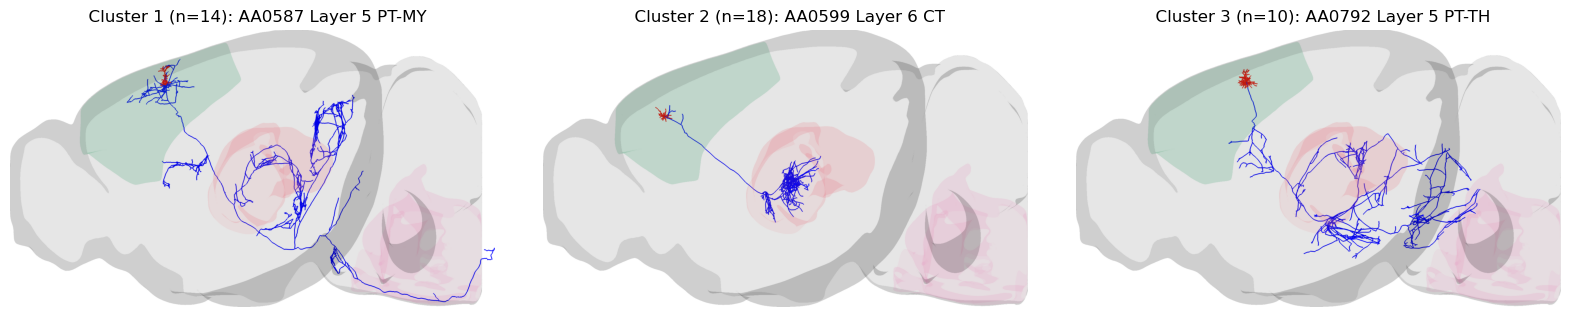

In [36]:
def get_cluster_exemplars(landscapes, labels, all_trees, method='medoid'):
    """
    Identify representative exemplars for each cluster.
    
    Parameters
    ----------
    landscapes : numpy.ndarray
        Landscape matrix of shape (n_samples, n_features)
    labels : numpy.ndarray
        Cluster labels for each sample
    all_trees : list
        List of Tree objects corresponding to landscape rows
    method : str, optional
        Method to select exemplars: 'medoid', 'centroid_nearest', or 'first'
        (default: 'medoid')
    
    Returns
    -------
    dict
        Dictionary mapping cluster_id -> (exemplar_tree, exemplar_index)
    """
    from scipy.spatial.distance import cdist
    import numpy as np
    
    exemplars = {}
    unique_labels = np.unique(labels)
    
    for cluster_id in unique_labels:
        # Get indices of samples in this cluster
        cluster_mask = labels == cluster_id
        cluster_indices = np.where(cluster_mask)[0]
        cluster_landscapes = landscapes[cluster_mask]
        
        if method == 'medoid':
            # Compute pairwise Chebyshev distances within cluster
            distances = cdist(cluster_landscapes, cluster_landscapes, metric='chebyshev')
            
            # Find sample with minimum average distance to all others
            avg_distances = distances.mean(axis=1)
            medoid_idx_in_cluster = np.argmin(avg_distances)
            exemplar_idx = cluster_indices[medoid_idx_in_cluster]
            
        elif method == 'centroid_nearest':
            # Find sample closest to cluster centroid
            centroid = cluster_landscapes.mean(axis=0)
            distances_to_centroid = cdist(cluster_landscapes, [centroid], metric='chebyshev')
            nearest_idx_in_cluster = np.argmin(distances_to_centroid)
            exemplar_idx = cluster_indices[nearest_idx_in_cluster]
            
        else:
            raise ValueError(f"Unknown method: {method}")
        
        exemplars[cluster_id] = (all_trees[exemplar_idx], exemplar_idx)
    
    return exemplars


# Cut tree at distance threshold to get clusters

from scipy.cluster.hierarchy import fcluster

# Create linkage matrix (same as in plot_dendrogram)
n_samples = len(model.labels_)
counts = np.zeros(model.children_.shape[0])
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([
    model.children_, 
    model.distances_, 
    counts
]).astype(float)
cluster_labels = fcluster(linkage_matrix, cut_distance, criterion='distance')

exemplars = get_cluster_exemplars(landscapes, cluster_labels, all_trees, method='medoid')
snapshots = []
print("Exemplars of clustered groups:")
for cluster_id in sorted(exemplars.keys()):
    tree, idx = exemplars[cluster_id]
    n_members = np.sum(cluster_labels == cluster_id)
    label = f"  Cluster {cluster_id} (n={n_members}): {tree.getLabel()}"

    # Assemble a 3D scene
    viewer = init_viewer()

    for compartment, color in {'axon' : 'blue', 'dendrites' : 'red'}.items():
        subtree = tree.subTree(compartment)
        subtree.setColor(color)
        viewer.addTree(subtree)

    # Collect scene snaphot
    snapshot = viewer.snapshot('sagittal')
    snapshot.setTitle(label)
    snapshots.append(snapshot)

pysnt.display(snapshots, panel_layout=(1,3), figsize=(20,10))


## Predicting Discriminatory Powers of Descriptors

To predict the utility of descriptor fuctions, we can plot the summaries of their output landscape side by side:

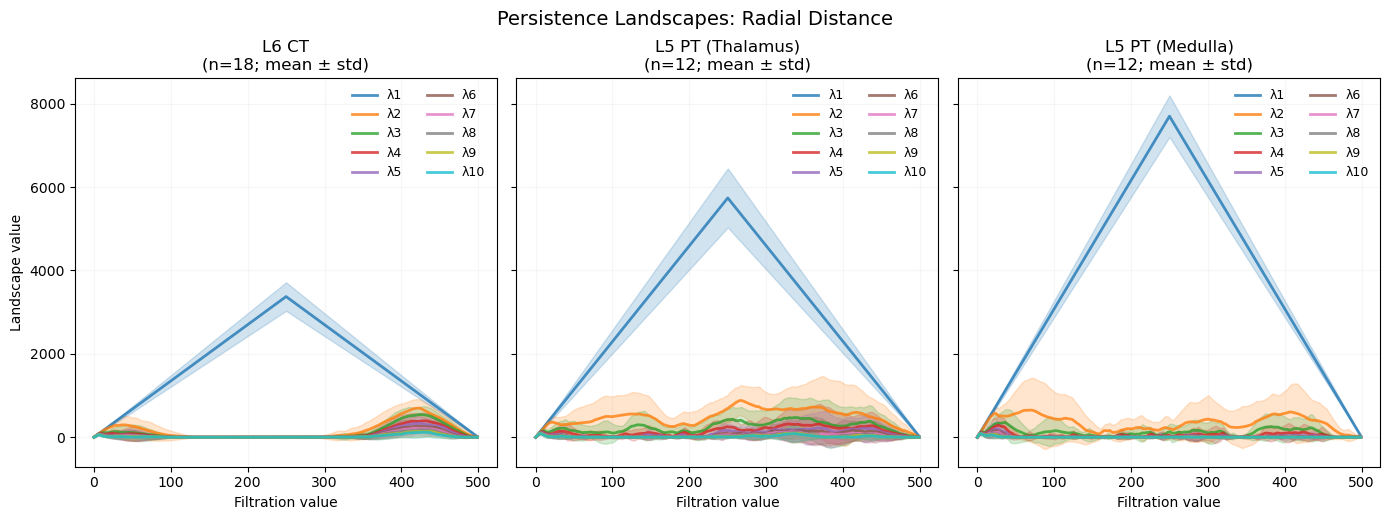

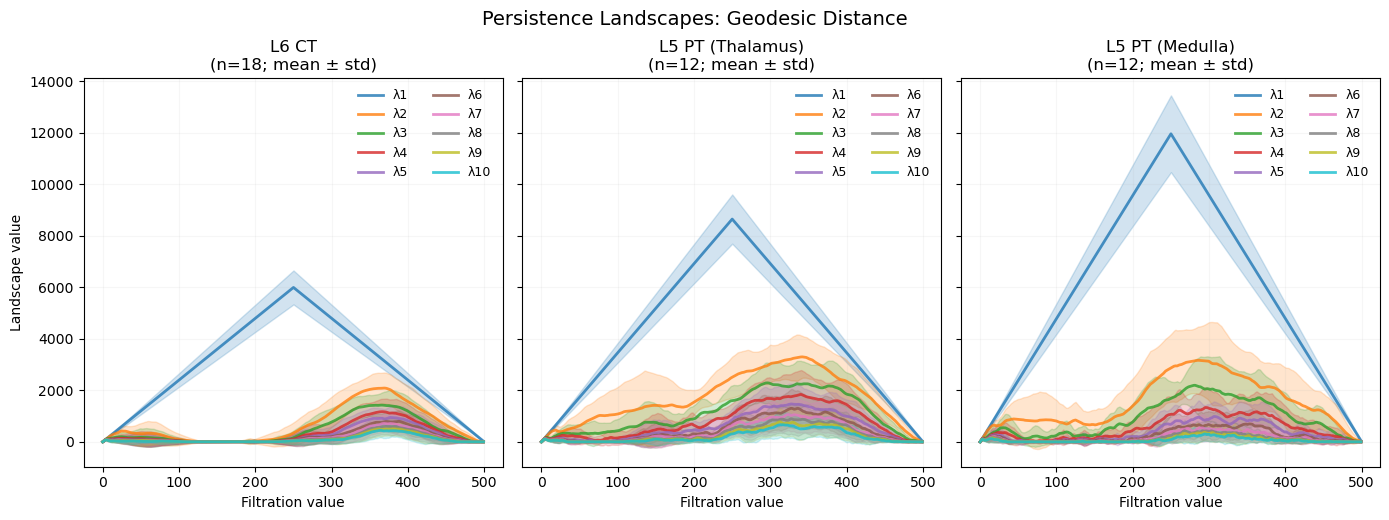

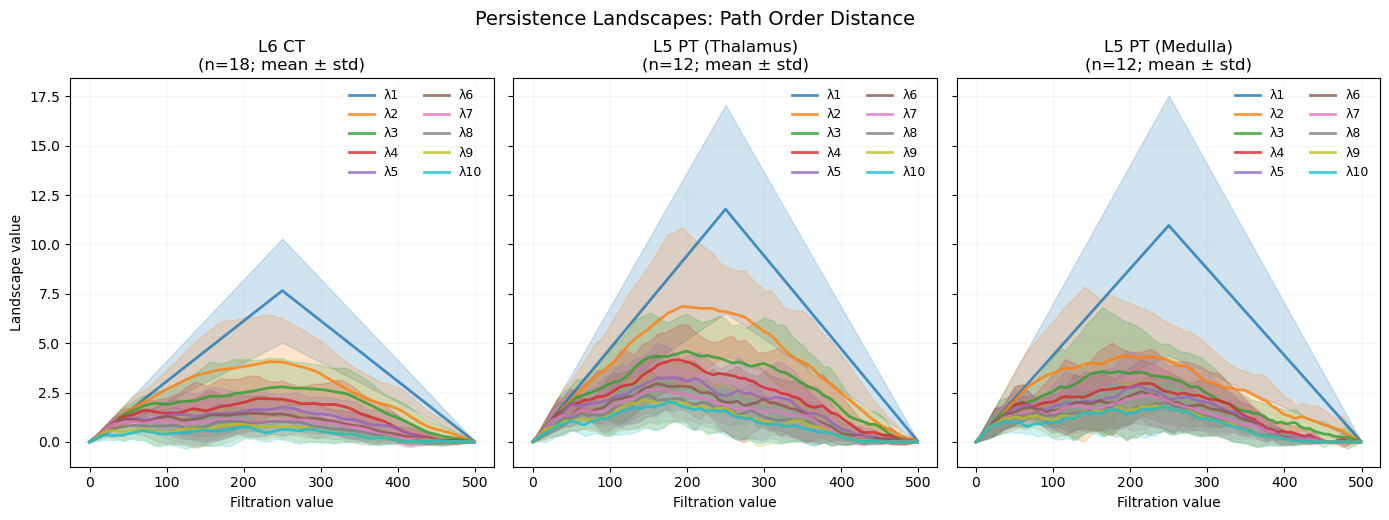

In [37]:
for descriptor in ['radial', 'geodesic', 'path order']:
    landscapes_desc = get_landscapes(all_trees, num_landscapes, resolution, descriptor=descriptor)
    fig, axes = plot_group_landscapes(
        # Reshape into 3D array: (neurons, landscapes, sample_points) for easier slicing
        all_ls=landscapes_desc.reshape(len(all_trees), num_landscapes, resolution),
        all_trees=all_trees,
        groups=original_groups,
        show_std=True
    )
    fig.suptitle(f'Persistence Landscapes: {descriptor.title()} Distance', fontsize=14, y=1.03)
    plt.show()

Key observations in terms of group discrimination:

- **Radial distance** (how far neurites extend from soma): Clear separation with distinct peak positions and amplitude. Strong λ₁ dominance.

- **Geodesic distance** (path length along branches): Clear amplitude separation (similar to radial). Perhaps because path lengths capture both spatial extent and [tortuosity](), λ₂ through λ₅ are more prominent than in radial distance, suggesting that Geodesic distance may provide more information in higher-order landscapes.

- **Path Order** (reconstruction hierarchy): Groups are much harder to distinguish: peaks are similar in both position and amplitude.

## Summary

In this tutorial, we demonstrated how persistent homology can be used for unsupervised classification of neuronal populations based solely on their morphological structure. Key findings include:

- Computed persistence landscapes from neuronal reconstructions using multiple descriptor functions (radial distance, geodesic distance, path order)
- Applied hierarchical clustering to group morphologically similar neurons
- Validated clustering results against known anatomical classifications
- Persistent homology successfully recovered known biological classifications without requiring labeled training data
- The choice of descriptor function impacts clustering quality—geometric descriptors (radial/geodesic) outperformed topological ones (path order) for these projection neurons

## Follow-up Questions

1. **Compartment-Specific Analysis**: How do clustering results differ when analyzing only dendritic or axonal arbors? Does separating compartments improve classification accuracy?

2. **Optimal Landscape Parameters**: How sensitive are results to the number of landscapes and resolution?

## Data Sources and References

Data used in this notebook is from the [MouseLight database](https://ml-neuronbrowser.janelia.org/), under a Creative Commons Attribution 4.0 International License ([CC BY 4.0](https://creativecommons.org/licenses/by/4.0/))

- The Allen Mouse Brain Common Coordinate Framework (CCFv3) is openly accessible at https://atlas.brain-map.org/ under the Allen Institute’s [Terms of Use](https://alleninstitute.org/terms-of-use/)

The Corticothalamic neurons are described in:
-  Winnubst J, Bas E, Ferreira TA, et al. Reconstruction of 1,000 Projection Neurons Reveals New Cell Types and Organization of Long-Range Connectivity in the Mouse Brain. Cell. 2019;179(1):268-281.e13. [doi:10.1016/j.cell.2019.07.042](https://doi.org/10.1016/j.cell.2019.07.042)

The Pyramidal-tract neurons are described in:
- Economo MN, Viswanathan S, Tasic B, et al. Distinct descending motor cortex pathways and their roles in movement. Nature. 2018;563(7729):79-84. [doi:10.1038/s41586-018-0642-9](https://doi.org/10.1038/s41586-018-0642-9)

See [SNT citation](https://imagej.net/plugins/snt/faq#how-do-i-cite-snt) for details on how to properly cite SNT.